In [3]:
from DatasetHandler.BiwiBrowser import *
import keras
import numpy as np
%matplotlib inline
#from keras import Model 
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
#from keras.preprocessing.sequence import TimeseriesGenerator

Using Theano backend.


In [4]:
num_outputs = 1

In [5]:
timesteps = 8
overlapping = True

In [6]:
subjectList = [9] #1, 2, 3, 4, 5, 7, 8, 11, 12, 14 except [6, 13, 10, ]
testSubjects = [9]

In [7]:
num_datasets = len(subjectList)

In [10]:
#keras.backend.clear_session()
def getFinalModel(num_outputs = num_outputs):
    dense_layer_1 = 1
    dense_layer_2 = 8
    inp = BIWI_Frame_Shape
    print(inp)
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(inp[0], inp[1], inp[2]))#timesteps, , input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(vgg_model)#)TimeDistributed(batch_size = timesteps, 
    
    #rnn.add(TimeDistributed(Flatten()))
    #rnn.add(LSTM(128, dropout=0.4, recurrent_dropout=0.2)) # , activation='relu', stateful=True
#    rnn.add(TimeDistributed(Dropout(0.2)))
    rnn.add(Dense(num_outputs))

    for layer in rnn.layers[:15]:
        layer.trainable = False
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [ ]:
full_model = getFinalModel(num_outputs = num_outputs)

(480, 640, 3)


In [121]:
#biwi = readBIWIDataset(subjectList = subjectList)#, timesteps = timesteps, overlapping = overlapping[s for s in range(1, num_datasets+1)]

In [122]:
def trainOnSets(model, set_gen):
    c = 0
    for inputMatrix, labels in set_gen:
        print('%d. dataset being trained!' % (c+1))
        data_gen = TimeseriesGenerator(inputMatrix, labels[:, 4:5], length=timesteps, batch_size=2)
        model.fit_generator(data_gen, steps_per_epoch=len(data_gen), epochs=1, verbose=1) 
        c += 1
    return model

In [123]:
def trainForEpochs(model, epochs, subjectList, testSubjects):
    trainingSubjects = [s for s in subjectList if s not in testSubjects]
    for e in range(epochs):
        trainingBiwi = readBIWIDataset(subjectList = trainingSubjects) 
        model = trainOnSets(model, trainingBiwi)
        print('Epoch %d completed!' % (e+1))
    return model

In [124]:
def getTestBiwi(testSubjects):
    test_generators, test_labelSets = [], [] 
    testBiwi = readBIWIDataset(subjectList = testSubjects) 
    for inputMatrix, labels in testBiwi:
        data_gen = TimeseriesGenerator(inputMatrix, labels[:, 4:5], length=timesteps, batch_size=4)
        test_generators.append(data_gen)
        test_labelSets.append(labels[:, 4:5])
    return test_generators, test_labelSets

In [125]:
test_generators, test_labelSets = getTestBiwi(testSubjects)
test_gen, test_labels = test_generators[0], test_labelSets[0] 

All frames and annotations from 1 datasets have been read by 2018-12-30 03:30:44.638408


In [126]:
full_model = trainForEpochs(full_model, 1, subjectList, testSubjects)

All frames and annotations from 4 datasets have been read by 2018-12-30 03:30:55.546023
1. dataset being trained!
Epoch 1/1
245/245 [==============================] - 109s 447ms/step - loss: 0.2260 - mean_absolute_error: 0.3789
2. dataset being trained!
Epoch 1/1
252/252 [==============================] - 114s 453ms/step - loss: 0.2257 - mean_absolute_error: 0.3813
3. dataset being trained!
Epoch 1/1
361/361 [==============================] - 164s 453ms/step - loss: 0.5908 - mean_absolute_error: 0.6671
4. dataset being trained!
Epoch 1/1
368/368 [==============================] - 167s 453ms/step - loss: 0.4212 - mean_absolute_error: 0.5389
Epoch 1 completed!


In [127]:
predictions = full_model.predict_generator(test_gen)

In [128]:
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

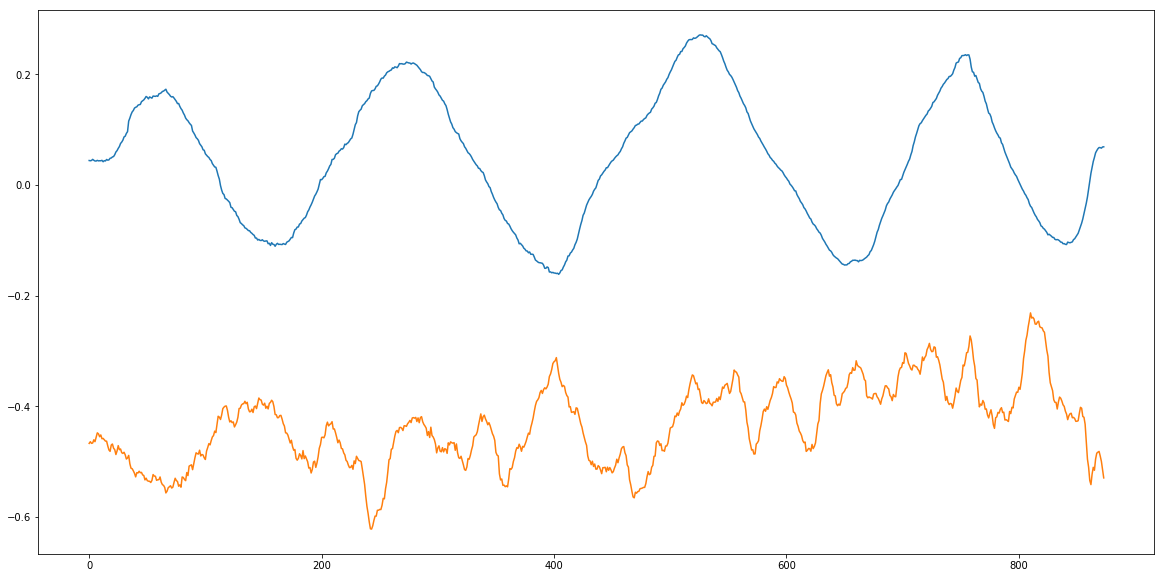

In [129]:
plt.figure(figsize=(20,10))
plt.plot(output1)